### Database Configurations

In [1]:
MONGO_URI = "mongodb://localhost:27017/?replicaSet=rs0"
DB_NAME = "simlab_db"

### Insert New Experiment Method

In [2]:
from pymongo import MongoClient
import gridfs
from datetime import datetime
from typing import Optional

def insert_file(path: str, name: str) -> str:
    """
    Armazena um arquivo no GridFS e retorna o ID.
    
    Args:
        path: Caminho completo do arquivo no sistema de arquivos
        name: Nome do arquivo a ser armazenado
        
    Returns:
        ID do arquivo no GridFS
    """
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]
    fs = gridfs.GridFS(db)
    
    with open(path, "rb") as f:
        file_id = fs.put(f, filename=name)
    
    client.close()
    return str(file_id)

def insert_experiment(
    experiment_data: dict,
    file_parameters: Optional[list[dict]] = None
) -> str:
    """
    Insere um experimento no MongoDB seguindo o formato do modelo C# atualizado.
    
    Args:
        experiment_data: Dicionário com os dados do experimento no formato:
            {
                "Name": str,
                "Status": str (opcional, default="Waiting"),
                "StartTime": str (ISO format) ou datetime,
                "EndTime": str (ISO format) ou datetime ou None (opcional),
                "Parameters": List[Dict] (ex: [{"Name": "param1", "Type": "float", "Value": "1.0"}]),
                "SimulationElements": Dict (conteúdo da simulação)
            }
        file_parameters: Lista de dicionários com arquivos para upload via GridFS:
            [{
                "Name": "nome_do_parametro",
                "FilePath": "/caminho/para/arquivo.txt"
            }]
            
    Returns:
        O _id do documento inserido
    """
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]
    collection = db["experiments"]
    
    # Prepara o documento base
    document = {
        "Name": experiment_data.get("Name", ""),
        "Status": experiment_data.get("Status", "Waiting"),
        "StartTime": experiment_data["StartTime"],
        "Parameters": experiment_data.get("Parameters", []),
        "SimulationElements": experiment_data.get("SimulationElements", {})
    }
    
    # Processa arquivos via GridFS se fornecidos
    if file_parameters:
        for file_param in file_parameters:
            try:
                file_id = insert_file(file_param["FilePath"], file_param["Name"])
                param = {
                    "Name": file_param["Name"],
                    "Type": "file",
                    "Value": file_id  # Armazena o ID do GridFS
                }
                document["Parameters"].append(param)
            except Exception as e:
                print(f"Erro ao processar arquivo {file_param['FilePath']}: {str(e)}")
                continue
    
    # Adiciona EndTime se existir
    if "EndTime" in experiment_data and experiment_data["EndTime"] is not None:
        document["EndTime"] = experiment_data["EndTime"]
    
    # Converte strings para datetime se necessário
    if isinstance(document["StartTime"], str):
        document["StartTime"] = datetime.fromisoformat(document["StartTime"])
    
    if "EndTime" in document and isinstance(document["EndTime"], str):
        document["EndTime"] = datetime.fromisoformat(document["EndTime"])
    
    # Valida os parâmetros
    for param in document["Parameters"]:
        if not all(key in param for key in ["Name", "Type", "Value"]):
            raise ValueError("Cada parâmetro deve conter 'Name', 'Type' e 'Value'")
    
    # Insere o documento no MongoDB
    result = collection.insert_one(document)
    client.close()
    
    return str(result.inserted_id)

### Start a New Experiment

In [3]:
import os
import json
from datetime import datetime

# Configurações
STATIC_DATA_DIR = "data"  # Diretório contendo os arquivos
SIM_ELEM_FILE = "simElem.json"   # Arquivo com os elementos de simulação
EXPERIMENT_NAME = "POC"

def load_simulation_elements(file_path: str) -> dict:
    """Carrega os elementos de simulação de um arquivo JSON"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Arquivo {file_path} não encontrado. Usando valores padrão.")
        return {"Model": "Default Model", "Config": {}}
    except json.JSONDecodeError:
        print(f"Erro ao decodificar {file_path}. Verifique se é um JSON válido.")
        return {"Model": "Default Model", "Config": {}}

def get_files_from_directory(directory: str) -> list[dict]:
    """Retorna lista de arquivos no diretório com seus caminhos completos"""
    file_params = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and filename != SIM_ELEM_FILE:  # Ignora o arquivo de simulação
            # Remove a extensão do arquivo para usar como nome do parâmetro
            param_name = os.path.splitext(filename)[0]
            file_params.append({
                "Name": param_name,
                "FilePath": file_path
            })
    return file_params

# Carrega os elementos de simulação do arquivo JSON
simulation_elements = load_simulation_elements(SIM_ELEM_FILE)

# Obtém todos os arquivos do diretório static-data (exceto simElem.json)
file_parameters = get_files_from_directory(STATIC_DATA_DIR)

# Verifica se encontrou arquivos
if not file_parameters:
    print(f"Nenhum arquivo encontrado no diretório {STATIC_DATA_DIR}")
else:
    print(f"Encontrados {len(file_parameters)} arquivos para processar")

# Dados do experimento
experiment_data = {
    "Name": EXPERIMENT_NAME,
    "Status": "Waiting",
    "StartTime": datetime.now().isoformat(),  # Usa o horário atual
    "Parameters": [
        {"Name": "PopSize", "Type": "int", "Value": "50"},
        {"Name": "Generations", "Type": "int", "Value": "30"},
        {"Name": "CrossoverProb", "Type": "float", "Value": "0.5"},
        {"Name": "MutationProb", "Type": "float", "Value": "0.1"},
        {"Name": "Divisions", "Type": "int", "Value": "32"},
        {"Name": "Algorithm", "Type": "string", "Value": "NSGA3"},
        {"Name": "Bound", "Type": "rectangle", "Value": "[(-100,-100),(100,100)]"},
    ],
    "SimulationElements": simulation_elements  # Usa os dados carregados do JSON
}

# Inserindo no MongoDB (se houver arquivos)
if file_parameters:
    inserted_id = insert_experiment(
        experiment_data=experiment_data,
        file_parameters=file_parameters
    )
    print(f"Documento inserido com ID: {inserted_id}")
    print(f"Total de arquivos processados: {len(file_parameters)}")
    print(f"Elementos de simulação carregados: {simulation_elements}")
else:
    print("Nenhum experimento foi inserido devido à falta de arquivos")

Encontrados 4 arquivos para processar
Documento inserido com ID: 67ed8ca5cd7ed4125ada52b7
Total de arquivos processados: 4
Elementos de simulação carregados: {'name': 'first-sim-lab', 'duration': 30, 'simulationElements': {'fixedMotes': [{'position': [0, 0], 'name': 'server', 'sourceCode': 'rpl-udp-server.c'}, {'position': [25, 25], 'name': 'client1', 'sourceCode': 'rpl-udp-client.c'}, {'position': [-25, 25], 'name': 'client2', 'sourceCode': 'rpl-udp-client.c'}, {'position': [25, -25], 'name': 'client3', 'sourceCode': 'rpl-udp-client.c'}, {'position': [-25, -25], 'name': 'client4', 'sourceCode': 'rpl-udp-client.c'}], 'mobileMotes': [{'functionPath': ['25 * np.cos(2 * np.pi * t)', '25 * np.sin(2 * np.pi * t)'], 'isClosed': True, 'isRoundTrip': False, 'speed': 5, 'timeStep': 1, 'name': 'client5', 'sourceCode': 'rpl-udp-client.c'}, {'functionPath': ['100 * t - 50', '50'], 'isClosed': False, 'isRoundTrip': True, 'speed': 3, 'timeStep': 2, 'name': 'client6', 'sourceCode': 'rpl-udp-client.c'

### Position Generator Method

In [4]:
import numpy as np
from typing import TypedDict

# Definindo tipos para type checking
class FixedMote(TypedDict):
    position: list[float]
    name: str
    sourceCode: str

class MobileMote(TypedDict):
    functionPath: list[str]
    isClosed: bool
    isRoundTrip: bool
    speed: float
    timeStep: float
    name: str
    sourceCode: str

class SimulationElements(TypedDict):
    fixedMotes: list[FixedMote]
    mobileMotes: list[MobileMote]

class SimulationConfig(TypedDict):
    name: str
    duration: float
    parameters: dict[str, str]
    simulationElements: SimulationElements

def evaluate_function(expression: str, t_values: np.ndarray) -> np.ndarray:
    """Avalia a função matemática dada como string para um conjunto de valores de t."""
    return np.array([eval(expression, {"t": t, "np": np}) for t in t_values])

def generate_positions_from_json(
    config: SimulationConfig, 
    output_filename: str = "positions.dat"
    ) -> tuple[list[tuple[float, float]], list[tuple[float, float]]]:
    """Gera arquivo de posições a partir da configuração JSON e retorna posições fixas e iniciais móveis."""
    fixed_positions = [(mote["position"][0], mote["position"][1]) for mote in config["simulationElements"]["fixedMotes"]]
    mobile_motes = config["simulationElements"]["mobileMotes"]
    
    mobile_start_positions = []
    
    with open(output_filename, "w") as file:
        # Escreve os motes fixos
        file.write("# Fixed positions\n")
        for i, (x, y) in enumerate(fixed_positions):
            file.write(f"{i} 0.00000000 {x:.2f} {y:.2f}\n")
        file.write("\n")
        
        # Escreve os motes móveis
        file.write("# Mobile nodes\n")
        mote_index = len(fixed_positions)
        max_steps = 0
        mobile_trajectories = []
        
        for mote in mobile_motes:
            x_expr, y_expr = mote["functionPath"]
            speed = mote["speed"]
            time_step = mote["timeStep"]
            is_round_trip = mote.get("isRoundTrip", False)
            
            # Avalia as funções de trajetória
            t_values = np.linspace(0, 1, num=100)
            x_values = evaluate_function(x_expr, t_values)
            y_values = evaluate_function(y_expr, t_values)
            
            # Armazena posição inicial
            mobile_start_positions.append((x_values[0], y_values[0]))
            
            # Calcula discretização baseada na velocidade
            distances = np.sqrt(np.diff(x_values)**2 + np.diff(y_values)**2)
            total_distance = np.sum(distances)
            duration = total_distance / speed
            steps = max(1, int(duration / time_step))
            max_steps = max(max_steps, steps)
            
            # Interpola para o número de passos calculado
            if steps > 1:
                x_interp = np.interp(np.linspace(0, 1, steps), t_values, x_values)
                y_interp = np.interp(np.linspace(0, 1, steps), t_values, y_values)
            else:
                x_interp = np.array([x_values[0]])
                y_interp = np.array([y_values[0]])
            
            # Trata round trip se necessário
            if is_round_trip:
                x_full = np.concatenate((x_interp, x_interp[::-1]))
                y_full = np.concatenate((y_interp, y_interp[::-1]))
            else:
                x_full = x_interp
                y_full = y_interp
            
            mobile_trajectories.append((mote_index, x_full, y_full, time_step))
            mote_index += 1
        
        # Escreve as posições no arquivo
        for step in range(2 * max_steps):
            for mote_id, x_full, y_full, time_step in mobile_trajectories:
                if step < len(x_full):
                    file.write(f"{mote_id} {step * time_step:.8f} {x_full[step]:.2f} {y_full[step]:.2f}\n")
            file.write("\n")
    
    print(f"File {output_filename}  generated successfully!")
    return fixed_positions, mobile_start_positions

### Simulation Cooja XML Generator Method

In [5]:
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def update_simulation_xml(
    fixed_positions: list[tuple[float, float]],
    mobile_positions: list[tuple[float, float]],
    root_motes: list[int],
    simulation_time: float,
    tx_range: float,
    interference_range: float,
    input_file: str,
    output_file: str
) -> None:
    """Atualiza arquivo XML de simulação com novos parâmetros.
    
    Args:
        fixed_positions: Lista de tuplas (x, y) com posições fixas
        mobile_positions: Lista de tuplas (x, y) com posições iniciais dos móveis
        root_motes: Lista de IDs dos motes servidores
        simulation_time: Tempo de simulação em minutos
        tx_range: Alcance de transmissão
        interference_range: Alcance de interferência
        inputFile: Caminho do arquivo XML de entrada (template)
        outputFile: Caminho do arquivo XML de saída
    """
    tree = ET.parse(input_file)
    root = tree.getroot()
    
    # Updates radio parameters
    radiomedium = root.find(".//radiomedium")
    if radiomedium is not None:
        transmitting_range = radiomedium.find("transmitting_range")
        if transmitting_range is not None:
            transmitting_range.text = str(tx_range)
        interference_range_elem = radiomedium.find("interference_range")
        if interference_range_elem is not None:
            interference_range_elem.text = str(interference_range)
    
    # Update simulation time in JS script keeping CDATA
    script_element = root.find(".//script")
    if script_element is not None and script_element.text is not None:
        script_text = script_element.text
        new_timeout = simulation_time * 60000  # Convertendo minutos para milissegundos
        script_text = script_text.replace("const timeOut = 9000000 * 1000;", f"const timeOut = {new_timeout} * 1000;")
        script_text = script_text.replace("TIMEOUT(9001000);", f"TIMEOUT({new_timeout + 1000});")
        script_element.text = f"<![CDATA[\n{script_text}\n]]>"
    
    # update motes
    motetype_root = root.find(".//motetype[description='server']")
    motetype_client = root.find(".//motetype[description='client']")
    
    if motetype_root is not None:
        for mote in motetype_root.findall("mote"):
            motetype_root.remove(mote)
    if motetype_client is not None:
        for mote in motetype_client.findall("mote"):
            motetype_client.remove(mote)
    
    for i, (x, y) in enumerate(fixed_positions + mobile_positions):
        mote_type = motetype_root if i + 1 in root_motes else motetype_client
        if mote_type is not None:
            mote = ET.SubElement(mote_type, "mote")
            
            interface_config = ET.SubElement(mote, "interface_config")
            interface_config.text = "org.contikios.cooja.interfaces.Position"
            ET.SubElement(interface_config, "pos", x=str(x), y=str(y))
            
            id_config = ET.SubElement(mote, "interface_config")
            id_config.text = "org.contikios.cooja.contikimote.interfaces.ContikiMoteID"
            ET.SubElement(id_config, "id").text = str(i + 1)
    
    xml_str = ET.tostring(root, encoding='utf-8')
    parsed_xml = minidom.parseString(xml_str)
    with open(output_file, "w", encoding="utf-8") as f:
        output = parsed_xml.toprettyxml(indent="  ")
        output = output.replace("?>", "encoding=\"UTF-8\"?>")
        output = output.replace("&gt;", ">")
        output = output.replace("&lt;", "<")
        output = output.replace("&quot;", "\"")
        output = output.replace("<![CDATA[\n", "<![CDATA[")
        output = output.replace("\n]]>", "]]>")
        
        # Remove blank lines, exceto dentro de CDATA
        inside_cdata = False
        lines_without_blanks = []
        for line in output.splitlines():
            if "<![CDATA[" in line:
                inside_cdata = True
            if inside_cdata or line.strip():
                lines_without_blanks.append(line)
            if "]]>" in line:
                inside_cdata = False
                
        final_content = "\n".join(lines_without_blanks)
        f.write(final_content)
    
    print(f"File {output_file} generated successfully!")

### Convert simElem.json

In [6]:
import json

def load_sim_config(file_path: str) -> SimulationConfig:
    """Carrega o arquivo de configuração JSON"""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def convert_simulation_files(
    json_file: str = "simElem.json", 
    template_file: str = "simulation_template.xml",
    outsim: str = "./temp/simulation.xml",
    outpos: str = "./temp/positions.dat"
    ):
    """Processa a simulação completa a partir dos arquivos de configuração."""
    # Carrega configuração
    config = load_sim_config(json_file)
    
    # Gera arquivo de posições e obtém posições iniciais
    fixed_positions, mobile_start_positions = generate_positions_from_json(
        config, 
        output_filename=outpos
    )
    
    # Identifica motes servidores (assume que o primeiro fixo é o servidor)
    root_motes = [1]
    
    # Gera arquivo XML de simulação
    update_simulation_xml(
        fixed_positions=fixed_positions,
        mobile_positions=mobile_start_positions,
        root_motes=root_motes,
        simulation_time=config["duration"],
        tx_range=50.0,
        interference_range=100.0,
        input_file=template_file,
        output_file=outsim
    )

# Processa configuração e gera arquivos
convert_simulation_files()

File ./temp/positions.dat  generated successfully!
File ./temp/simulation.xml generated successfully!


### Plot Positions Methods

In [7]:
import matplotlib.pyplot as plt

def plot_positions(filename="positions.dat"):
    fixed_positions = []
    mobile_positions = {}
    
    with open(filename, "r") as file:
        for line in file:
            if line.startswith("#") or line.strip() == "":
                continue
            parts = line.split()
            mote_id, _, x, y = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])
            
            if mote_id not in mobile_positions and len(fixed_positions) > mote_id:
                fixed_positions.append((x, y))
            else:
                if mote_id not in mobile_positions:
                    mobile_positions[mote_id] = []
                mobile_positions[mote_id].append((x, y))
    
    plt.figure(figsize=(8, 8))
    
    # Plot fixed motes
    if fixed_positions:
        x_fixed, y_fixed = zip(*fixed_positions)
        plt.scatter(x_fixed, y_fixed, color='red', marker='o', label='Fixed Nodes')
    
    # Plot mobile motes
    for mote_id, positions in mobile_positions.items():
        x_mobile, y_mobile = zip(*positions)
        plt.plot(x_mobile, y_mobile, marker='o', linestyle='-', label=f'Mobile Node {mote_id}')
    
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Node Positions")
    plt.legend()
    plt.grid()    
    plt.axis("equal")
    plt.show()
    
def plot_positions_with_radius(filename="positions.dat", radius=10):
    fixed_positions = []
    mobile_positions = {}
    
    with open(filename, "r") as file:
        for line in file:
            if line.startswith("#") or line.strip() == "":
                continue
            parts = line.split()
            mote_id, _, x, y = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])
            
            if mote_id not in mobile_positions and len(fixed_positions) > mote_id:
                fixed_positions.append((x, y))
            else:
                if mote_id not in mobile_positions:
                    mobile_positions[mote_id] = []
                mobile_positions[mote_id].append((x, y))
    
    plt.figure(figsize=(8, 8))
    
    # Plot fixed motes
    if fixed_positions:
        x_fixed, y_fixed = zip(*fixed_positions)
        plt.scatter(x_fixed, y_fixed, color='red', marker='o', label='Fixed Nodes')
        for x, y in fixed_positions:
            circle = plt.Circle((x, y), radius, color='red', linestyle='dashed', fill=False)
            plt.gca().add_patch(circle)
    
    # Plot mobile motes
    for mote_id, positions in mobile_positions.items():
        x_mobile, y_mobile = zip(*positions)
        plt.plot(x_mobile, y_mobile, marker='o', linestyle='-', label=f'Mobile Node {mote_id}')
        for x, y in positions:
            circle = plt.Circle((x, y), radius, color='blue', linestyle='dashed', fill=False)
            plt.gca().add_patch(circle)
    
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Node Positions with Coverage Circles")
    plt.legend()
    plt.grid()
    plt.axis("equal")
    plt.show()

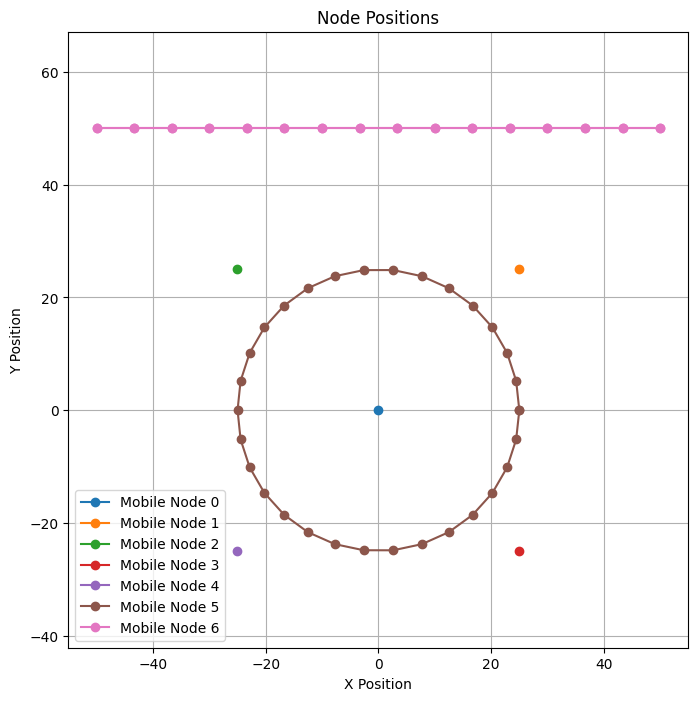

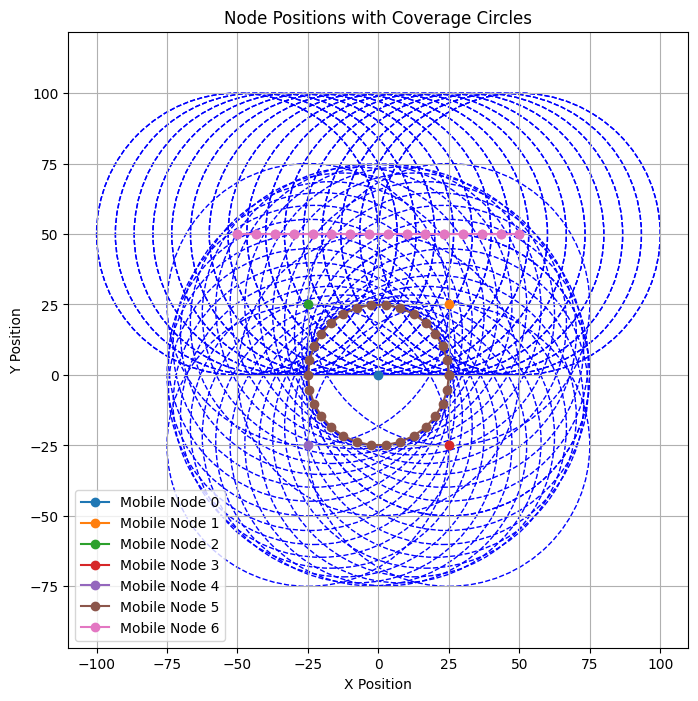

In [8]:
plot_positions("./temp/positions.dat")
plot_positions_with_radius("./temp/positions.dat", radius=50)

In [9]:
from pymongo import MongoClient
from typing import Tuple, List, Dict
from datetime import datetime

def get_experiments_by_status() -> Tuple[List[Dict], List[Dict]]:
    """
    Retorna duas listas de experimentos: os com status 'Running' e os com status 'Waiting'.
    
    Returns:
        Tuple contendo:
        - Lista de experimentos com status 'Running'
        - Lista de experimentos com status 'Waiting'
    """
    client = None
    try:
        client = MongoClient(MONGO_URI)
        db = client[DB_NAME]
        collection = db["experiments"]
        
        # Consulta experimentos com status 'Running'
        running_experiments = list(collection.find({"Status": "Running"}))
        
        # Consulta experimentos com status 'Waiting'
        waiting_experiments = list(collection.find({"Status": "Waiting"}))
        
        # Converte ObjectId para string e formata datas
        for exp in running_experiments + waiting_experiments:
            exp["_id"] = str(exp["_id"])
            if isinstance(exp.get("StartTime"), datetime):
                exp["StartTime"] = exp["StartTime"].isoformat()
            if isinstance(exp.get("EndTime"), datetime):
                exp["EndTime"] = exp["EndTime"].isoformat()
        
        return running_experiments, waiting_experiments
        
    except Exception as e:
        print(f"Erro ao consultar experimentos: {str(e)}")
        return [], []
    finally:
        if client:
            client.close()

# Exemplo de uso:
running, waiting = get_experiments_by_status()

print("\nExperimentos em execução (Running):")
for exp in running:
    print(f"ID: {exp['_id']}, Nome: {exp.get('Name', 'N/A')}, "
            f"Início: {exp.get('StartTime', 'N/A')}")

print("\nExperimentos aguardando (Waiting):")
for exp in waiting:
    print(f"ID: {exp['_id']}, Nome: {exp.get('Name', 'N/A')}, "
            f"Início: {exp.get('StartTime', 'N/A')}")


Experimentos em execução (Running):

Experimentos aguardando (Waiting):
ID: 67ed8ca5cd7ed4125ada52b7, Nome: POC, Início: 2025-04-02T16:14:45.490000


In [10]:
# Após inserir experimentos como no seu código anterior

# Consultar status dos experimentos
running_exps, waiting_exps = get_experiments_by_status()

print(f"\nTotal de experimentos em execução: {len(running_exps)}")
print(f"Total de experimentos aguardando: {len(waiting_exps)}")

# Atualizar status de um experimento (exemplo)
if waiting_exps:
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]
    db.experiments.update_one(
        {"_id": waiting_exps[0]["_id"]},
        {"$set": {"Status": "Running"}}
    )
    client.close()
    print("\nStatus de um experimento atualizado de Waiting para Running")


Total de experimentos em execução: 0
Total de experimentos aguardando: 1

Status de um experimento atualizado de Waiting para Running
